In [1]:
from lux.lux import LUX
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
from anchor import utils
from anchor import anchor_tabular
from sklearn.preprocessing import normalize, MinMaxScaler

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Make moons

In [3]:
X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
Xdf = pd.DataFrame(X, columns=['x1','x2'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['x1','x2']
X_test.columns = ['x1','x2']

<Axes: xlabel='x1', ylabel='x2'>

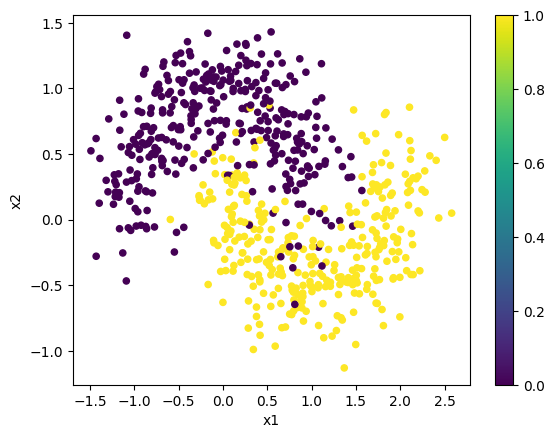

In [5]:
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis')

In [6]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.91      0.94      0.93       177

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [7]:
from sklearn.linear_model import LogisticRegression
xclf = RandomForestClassifier()
xclf.fit(X_train, y_train)
lr_preds = xclf.predict(X_test)

In [8]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.9303030303030303
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       153
           1       0.93      0.94      0.94       177

    accuracy                           0.93       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



<Axes: xlabel='x1', ylabel='x2'>

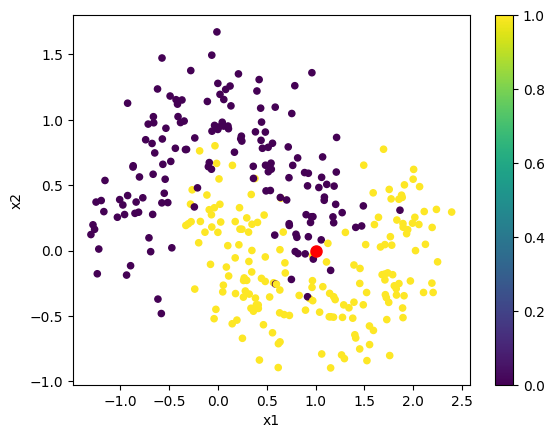

In [9]:
fig, ax = plt.subplots()
point = [1.0,0.0]
ax.plot(point[0], point[1], 'or', markersize=8)
X_test.plot(kind='scatter',x='x1', y='x2', c=y_test, colormap='viridis', ax=ax)

In [10]:
X_test_appended = pd.concat((X_test,pd.DataFrame([point], columns=['x1','x2'])))
y_test_appended = np.concatenate([y_test,[1]])

## Decision Boundaries

X does not have valid feature names, but SVC was fitted with feature names


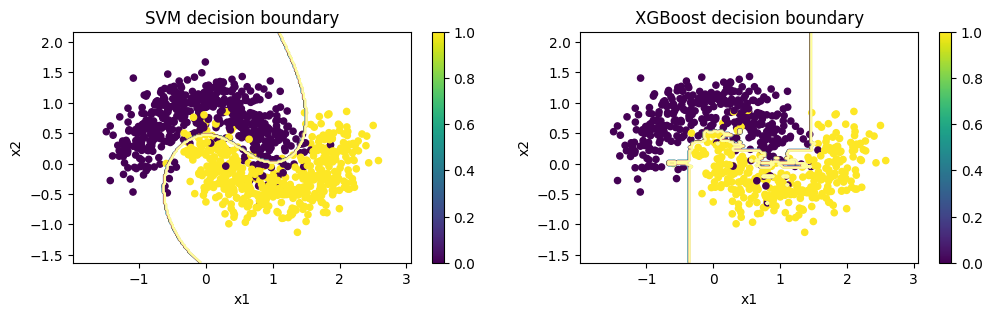

In [11]:

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='x1', y='x2',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

## Confidence plots

X does not have valid feature names, but SVC was fitted with feature names


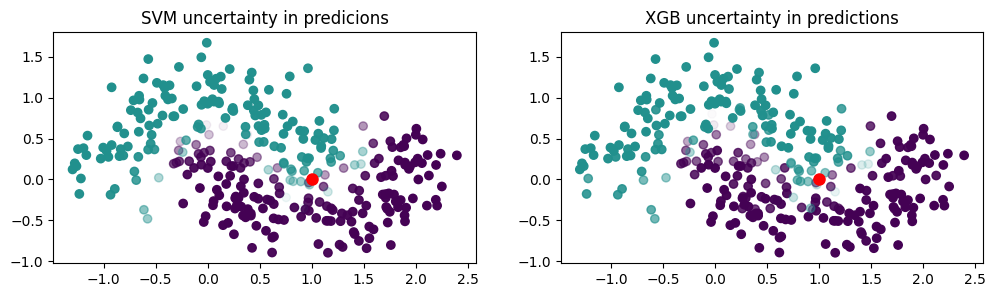

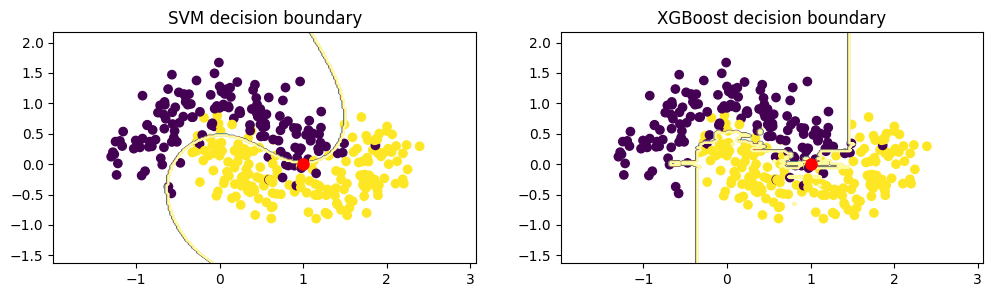

In [12]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_test_appended)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = xclf.predict_proba(X_test_appended)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_svc.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_xgb.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_xgb.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)


fig.savefig('uncertainty-point.png')

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
fig.savefig('decbound-point.png')
plt.show()

## Lime explanations

In [13]:
point

[1.0, 0.0]

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=list(X_train.columns), class_names=['0','1'], discretize_continuous=True)

In [15]:
idx = len(X_test_appended)-1
exp = explainer.explain_instance(X_test_appended.iloc[idx,:], svc.predict_proba, num_features=2, top_labels=1)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but SVC was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is dep

In [16]:
exp.show_in_notebook(show_table=True, show_all=False)

## Shap explanations

In [17]:
shap.initjs()

In [18]:
point

[1.0, 0.0]

In [19]:
import warnings
warnings.filterwarnings('ignore')

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svc.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test_appended, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
idx = len(X_test_appended)-1
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], X_test_appended.iloc[idx,:], link="logit")

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:14<00:00, 23.60it/s]


## Anchor explanations

In [20]:
explainer = anchor_tabular.AnchorTabularExplainer(
    ['0','1'],
    feature_names = X_train.columns,
    train_data = X_train.values,
    categorical_names={})

In [21]:
np.random.seed(1)
print('Prediction: ', explainer.class_names[svc.predict(X_test_appended.iloc[idx].values.reshape(1,-1))[0]])
exp = explainer.explain_instance(X_test_appended.iloc[idx].values, svc.predict, threshold=0.95)

Prediction:  1


In [22]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x2 <= 0.29 AND x1 > -0.17
Precision: 0.96
Coverage: 0.45


## LUX explanations

In [23]:
lux = LUX(predict_proba = svc.predict_proba, neighborhood_size=100,max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(X_train, y_train, instance_to_explain=point,class_names=[0,1])

In [24]:
preds =[int(v) for v in lux.predict(X_train)]

In [25]:
sum(preds==y_train)/len(y_train)

0.826865671641791

### Single rule justification

In [26]:
lux.justify(np.array([point]))

['IF x2 <0.0028388574719429016 THEN class = 1 # 1.0\n']

### Counterfactual explanation

In [27]:
lux.counterfactual(np.array([point]), X_train, counterfactual_representative='nearest', topn=1)

[{'rule': {'x2': ['<0.0028388574719429016']},
  'prediction': '1',
  'confidence': 1.0,
  'covered':            x1        x2
  547  0.434572 -0.019075
  872  0.222299 -0.253391
  404  0.280332 -0.185768
  125  1.713620 -0.375723
  420  0.773221 -0.123677
  ..        ...       ...
  214  1.768187 -0.212819
  466  0.074815 -0.229663
  121  1.332775 -0.436298
  106  0.652965 -0.639610
  270  1.260014 -0.344153
  
  [230 rows x 2 columns],
  'counterfactual': x1    0.870092
  x2   -0.044982
  Name: 43, dtype: float64,
  'distance': array([[0.13747515]])}]

### Whole tree justification

In [28]:
print(lux.to_HMR())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TYPES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%

xtype [
 name: class, 
base:symbolic,
 domain : [1,0]].
xtype [
 name: x2, 
base:numeric,
domain : [-100000 to 100000]].

%%%%%%%%%%%%%%%%%%%%%%%%% ATTRIBUTES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%
xattr [ name: class,
 type:class,
 class:simple,
 comm:out ].
xattr [ name: x2,
 type:x2,
 class:simple,
 comm:out ].

%%%%%%%%%%%%%%%%%%%%%%%% TABLE SCHEMAS DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%
 xschm tree : [x2]==> [class].
xrule tree/0:
[x2  lt 0.11804039403796196, x2  lt 0.0028388574719429016] ==> [class set 1]. # 1.0
xrule tree/1:
[x2  lt 0.11804039403796196, x2  gte 0.0028388574719429016] ==> [class set 1]. # 0.6153846153846154
xrule tree/2:
[x2  gte 0.11804039403796196] ==> [class set 0]. # 1.0



# Iris example

In [29]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'class'

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris)
clf = svm.SVC(probability=True)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.9736842105263158

In [30]:
#pick some instance from datasetr
iris_instance = train[features].sample(1).values
iris_instance

#train lux on neighbourhood equal 20 instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=20,max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF petal_length >=4.8999998569488525 THEN class = 2 # 1.0\n']

In [31]:
## Generate counterfactual
cf = lux.counterfactual(np.array(iris_instance), train[features], counterfactual_representative='nearest', topn=1)[0]
print(f"Counterfactual for {iris_instance} to change from class {lux.predict(np.array(iris_instance))[0]} to class {cf['prediction']}: \n{cf['counterfactual']}")

Counterfactual for [[7.7 3.  6.1 2.3]] to change from class 2 to class 1: 
sepal_length    7.0
sepal_width     3.2
petal_length    4.7
petal_width     1.4
Name: 50, dtype: float64


In [32]:
#have a look at the entire rule-based model that can be executed with https:://heartdroid.re
print(lux.to_HMR())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TYPES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%

xtype [
 name: class, 
base:symbolic,
 domain : [1,0,2]].
xtype [
 name: petal_length, 
base:numeric,
domain : [-100000 to 100000]].

%%%%%%%%%%%%%%%%%%%%%%%%% ATTRIBUTES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%
xattr [ name: class,
 type:class,
 class:simple,
 comm:out ].
xattr [ name: petal_length,
 type:petal_length,
 class:simple,
 comm:out ].

%%%%%%%%%%%%%%%%%%%%%%%% TABLE SCHEMAS DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%
 xschm tree : [petal_length]==> [class].
xrule tree/0:
[petal_length  lt 2.949999988079071] ==> [class set 0]. # 1.0
xrule tree/1:
[petal_length  gte 2.949999988079071, petal_length  lt 4.8999998569488525] ==> [class set 1]. # 1.0
xrule tree/2:
[petal_length  gte 2.949999988079071, petal_length  gte 4.8999998569488525] ==> [class set 2]. # 1.0



In [33]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
lux.uid3.tree.save_dot('tree.dot',fmt='.2f',visual=True, background_data=train)
gvz=graphviz.Source.from_file('tree.dot')
!dot -Tpng tree.dot > tree.png
Image('tree.png')

PermissionError: [Errno 13] Permission denied: '/imgs/'